<a href="https://colab.research.google.com/github/Sniper202/Detecccion-de-defectos-en-chips-de-papa/blob/main/Copia_de_MODELOUNETAUSAR_256_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image
import json

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
PATH = '/content/drive/MyDrive/MODELOUNET29_01_24'
train_path ='/content/drive/MyDrive/MODELOUNET29_01_24/DATA/Data_Augmentation'
train_mask_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/Data_mask'

In [ ]:
class Potato_Dataset(Dataset):
    def __init__(self,data, masks = None, img_transforms = None, mask_transforms = None) :
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_mask = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_mask))

    def __len__(self):
        if self.train_mask is not None:
            assert len(self.images) == len(self.masks)
        return len(self.images)

    def __getitem__(self, index):
        image_name = os.path.join(self.train_data, self.images[index])
        img = Image.open(image_name)
        transf= T.ToTensor()
        if self.img_transforms:
            img = self.img_transforms(img)
        else:
            img = transf(img)


        if self.train_mask:
            mask_name = os.path.join(self.train_mask,self.masks[index])
            mask = Image.open(mask_name)
            if self.mask_transforms:
                mask = self.mask_transforms(mask)
            else:
                mask = transf(mask)

            mask_max = mask.max().item()
            mask /= mask_max

        else:
            return img

        return img, mask

In [ ]:
transform_data = T.Compose([
                    T. Resize([256,256]),
                    T.ToTensor()
                    ])

# Dataloaders

full_dataset = Potato_Dataset( train_path,
                                  train_mask_path,
                                  img_transforms = transform_data,
                                  mask_transforms = transform_data)

In [ ]:
BATCH_SIZE = 12
Train_size = int(len(full_dataset)*0.8)
Val_size = len(full_dataset) - Train_size

print(Train_size,Val_size)

train_data, val_data = random_split(full_dataset,[Train_size,Val_size])
print (len(train_data), len(val_data))


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=True)

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9:break

256 64
256 64
torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
0 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
1 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
2 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
3 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
4 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
5 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
6 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
7 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
8 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])
9 torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])


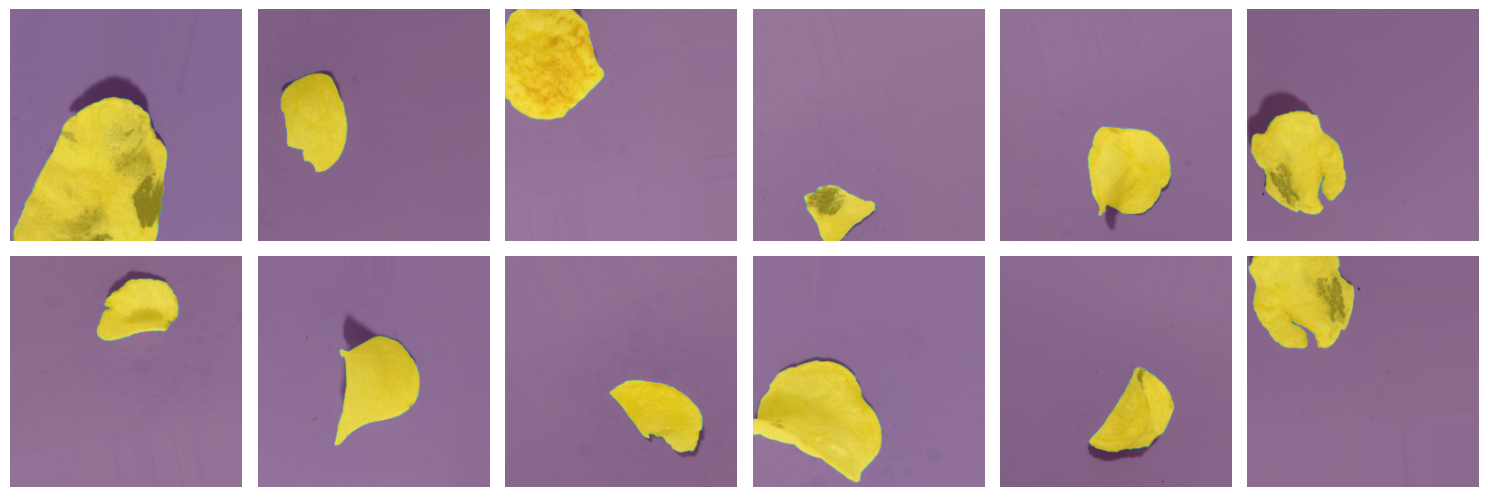

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs,masks):
    plt.figure(figsize=(15,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4,6,i+1)
        img = imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i,...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()
plot_mini_batch(imgs, masks)

In [ ]:

class Conv_3_k(nn.Module):
    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in,channels_out, kernel_size=3,stride=1,padding=1)

    def forward(self, x ):
        return self.conv1(x)

class Double_Conv(nn.Module):

    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            Conv_3_k(channels_in,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            Conv_3_k(channels_out,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2,2),
            Double_Conv(channels_in,channels_out)
        )
    def forward(self,x):
        return self.encoder(x)


class Up_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='bicubic'),
            nn.Conv2d(channels_in,channels_in//2,kernel_size=1,stride=1)
        )

        self.decoder = Double_Conv(channels_in,channels_out)

    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x =  torch.cat([x2,x1],dim=1)
        return self.decoder(x)


class UNET_potato_model(nn.Module):


    def __init__(self, channels_in, channels, num_class ):
        super().__init__()
        self.f_conv = Double_Conv(channels_in, channels)
        self.down_conv1 = Down_conv(channels, 2*channels)
        self.down_conv2 = Down_conv(2*channels,4*channels)

        self.middle_conv = Down_conv(4*channels,8*channels)

        self.up_conv1 = Up_conv(8*channels, 4*channels)
        self.up_conv2 = Up_conv(4*channels, 2*channels)
        self.up_conv3 = Up_conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_class, kernel_size=1,stride=1)

    def forward(self, x):
        x1 = self.f_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)

        x4 = self.middle_conv(x3)

        x5 = self.up_conv1(x4,x3)
        x6 = self.up_conv2(x5,x2)
        x7 = self.up_conv3(x6,x1)


        return self.last_conv(x7)


In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)

        optimiser.zero_grad()
        scores = model(x)

        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()

        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)

        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
        losses.append(avg_loss)
        log_lrs.append(lr)

        cost.backward()
        optimiser.step()

        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

In [ ]:
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.6965, lr: 0.0000, acc: 0.3095
cost:0.7132, lr: 0.0000, acc: 0.2765
cost:0.6979, lr: 0.0000, acc: 0.3065
cost:0.7160, lr: 0.0000, acc: 0.2853
cost:0.7100, lr: 0.0000, acc: 0.2945
cost:0.6869, lr: 0.0000, acc: 0.3217
cost:0.6739, lr: 0.0000, acc: 0.3478
cost:0.6879, lr: 0.0000, acc: 0.3227
cost:0.6780, lr: 0.0001, acc: 0.3277
cost:0.6311, lr: 0.0001, acc: 0.3727
cost:0.6098, lr: 0.0002, acc: 0.4010
cost:0.5758, lr: 0.0003, acc: 0.4344
cost:0.5423, lr: 0.0005, acc: 0.4647
cost:0.5153, lr: 0.0009, acc: 0.4772
cost:0.4770, lr: 0.0014, acc: 0.4789
cost:0.4406, lr: 0.0024, acc: 0.4753
cost:0.3989, lr: 0.0041, acc: 0.4827
cost:0.3706, lr: 0.0069, acc: 0.4849
cost:0.3394, lr: 0.0116, acc: 0.4899
cost:0.3130, lr: 0.0195, acc: 0.4892
cost:0.3054, lr: 0.0328, acc: 0.4849
cost:0.1739, lr: 0.0552, acc: 0.4933
cost:0.1197, lr: 0.0928, acc: 0.4879
cost:0.0662, lr: 0.1562, acc: 0.4913
cost:0.0818, lr: 0.2626, acc: 0.4880
cost:0.0550, lr: 0.4417, acc: 0.4893
cost:0.1228, lr: 0.7430, acc: 0.4873
c

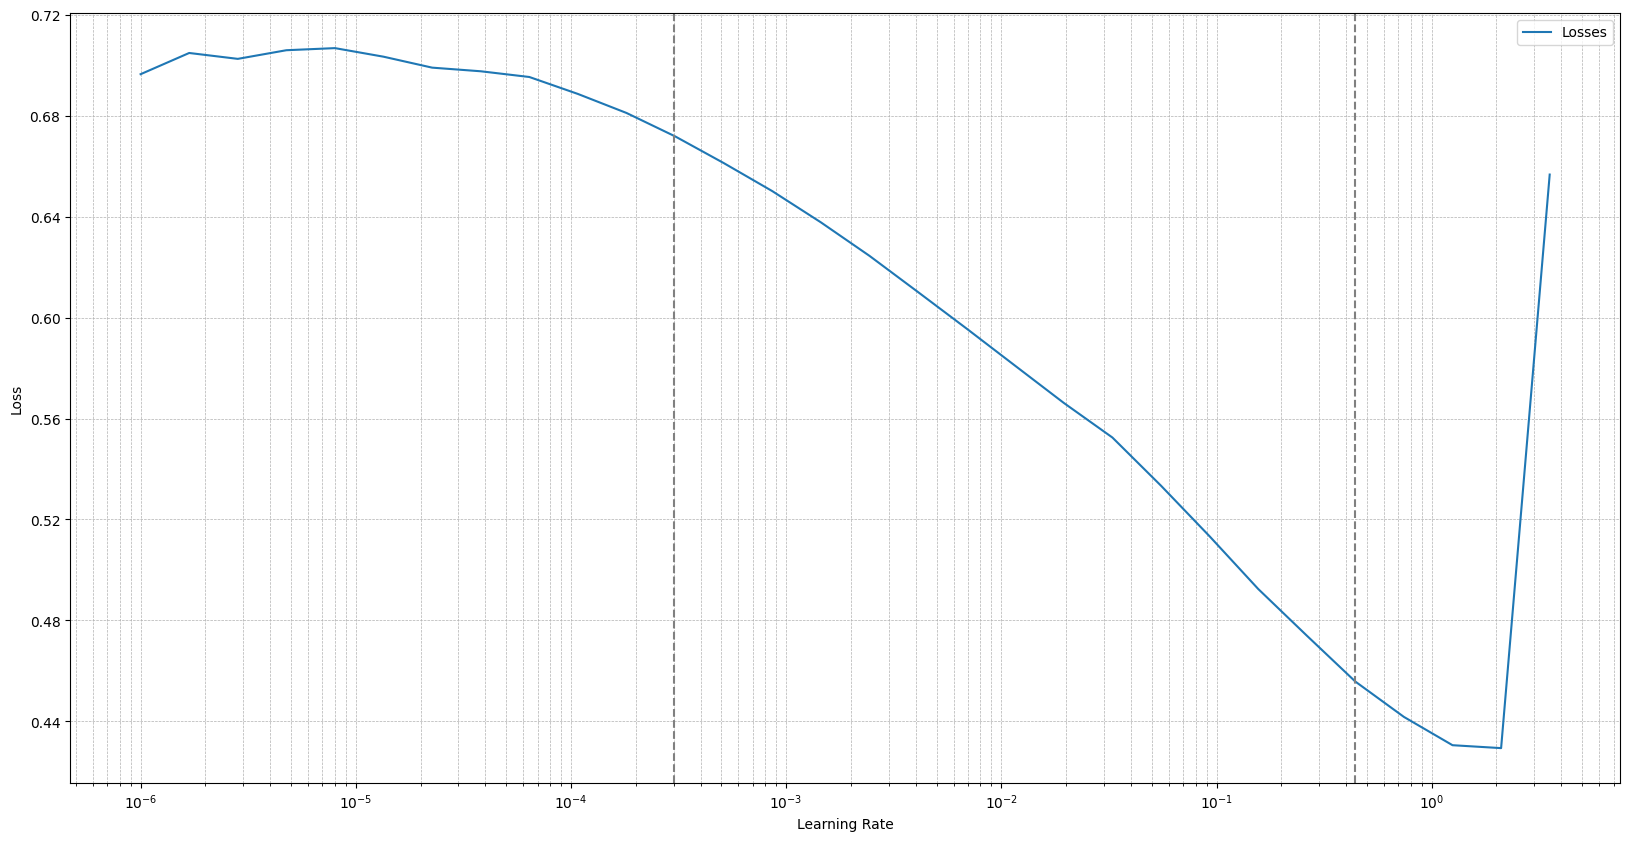

In [ ]:
p = (0.0003,0.5758)
fl, axl = plt.subplots(figsize =(20,10))
axl.plot(lg_lr, losses,label ='Losses')
axl.set_xscale('log')
axl.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))
axl.set_xlabel('Learning Rate')
axl.set_ylabel('Loss')
axl.axvline(p[0], color='gray', linestyle='--')
axl.axvline(p[1], color='gray', linestyle='--')
axl.grid(True,which='both',linestyle ='--', linewidth = 0.5)
axl.legend()

plt.show()

torch.Size([12, 256, 256])


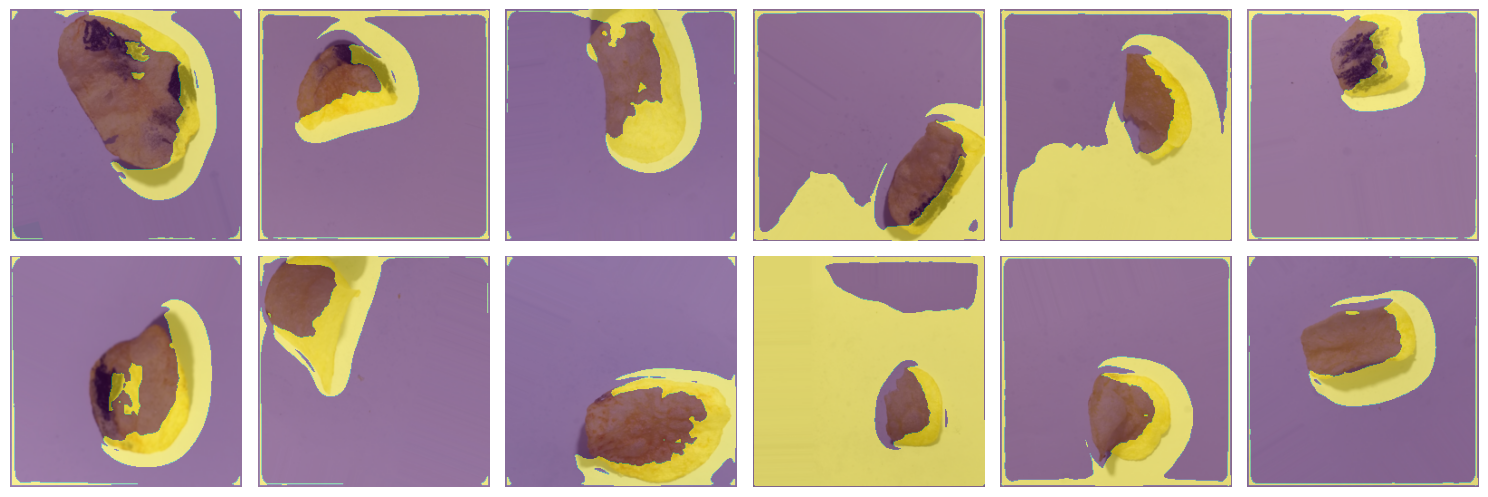

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
def train(model, optimiser, scheduler=None, epochs=100, store_every=15, save_path='best_model.pt'):
    model = model.to(device=device)

    train_loss_h, val_loss_h = [], []
    train_acc_h, val_acc_h = [], []
    train_IoU, val_dice = [], []

    best_val_acc = 0.0
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()

            if mb % store_every == 0:
              # Permite calcular train_acc solo cuando train_total es mayor que cero
                if train_total > 0:
                    train_acc = float(train_correct_num) / train_total
                else:
                    train_acc = 0.0

                train_cost_every = float(train_cost_acum) / mb

                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb

                val_loss_h.append(val_cost)
                val_acc_h.append(val_acc)

                train_loss_h.append(train_cost_every)
                train_acc_h.append(train_acc)
                train_IoU.append(iou)
                val_dice.append(dice)

                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice:.5f}, iou: {iou:.5f}')

                # Permite guardar el modelo sólo cuando se observa mejorías en el val_acc
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), save_path)

    return train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU, val_dice

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO1_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.0003,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice = train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.6230, val cost: 0.5613,train acc: 0.7698, val acc: 0.8915,dice: 0.64672, iou: 0.47789
epoch: 1, mb: 15, train cost: 0.4958, val cost: 0.4709,train acc: 0.9543, val acc: 0.9641,dice: 0.88257, iou: 0.78983
epoch: 2, mb: 15, train cost: 0.4387, val cost: 0.4235,train acc: 0.9698, val acc: 0.9726,dice: 0.90922, iou: 0.83355
epoch: 3, mb: 15, train cost: 0.4007, val cost: 0.3927,train acc: 0.9791, val acc: 0.9801,dice: 0.93276, iou: 0.87399
epoch: 4, mb: 15, train cost: 0.3795, val cost: 0.3700,train acc: 0.9859, val acc: 0.9869,dice: 0.95452, iou: 0.91301
epoch: 5, mb: 15, train cost: 0.3593, val cost: 0.3508,train acc: 0.9895, val acc: 0.9907,dice: 0.96725, iou: 0.93657
epoch: 6, mb: 15, train cost: 0.3437, val cost: 0.3354,train acc: 0.9923, val acc: 0.9934,dice: 0.97645, iou: 0.95399
epoch: 7, mb: 15, train cost: 0.3269, val cost: 0.3177,train acc: 0.9931, val acc: 0.9938,dice: 0.97800, iou: 0.95694
epoch: 8, mb: 15, train cost: 0.3067, val cost: 0.2972,t

In [ ]:
test_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/Test'
test_set = Potato_Dataset(test_path, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([12, 256, 256])


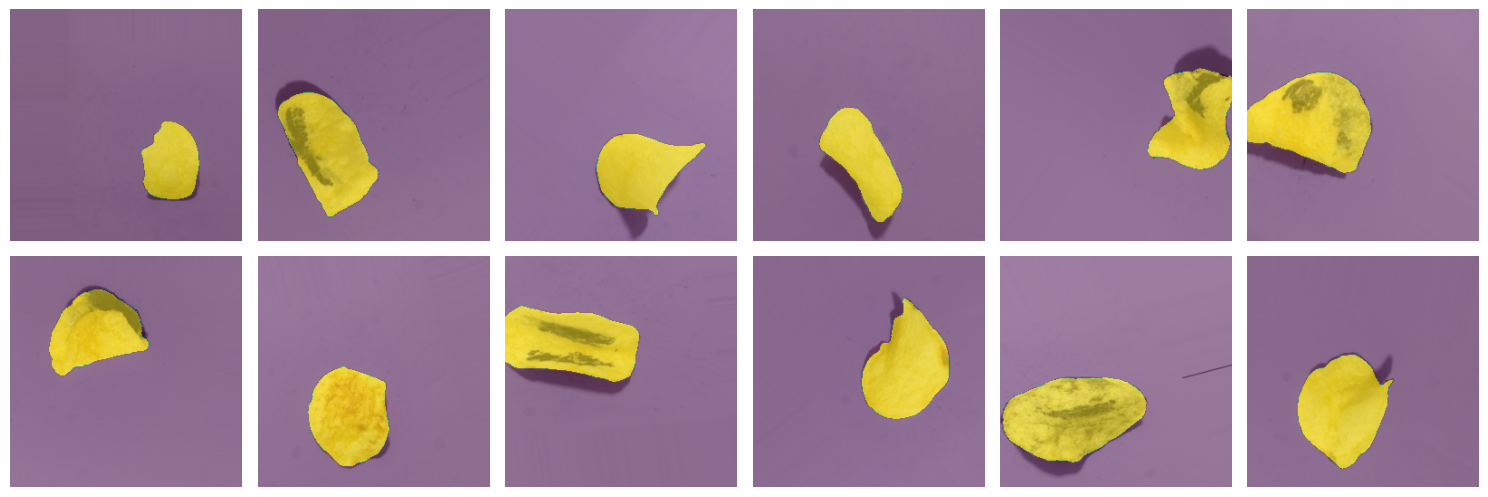

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

torch.Size([12, 256, 256])


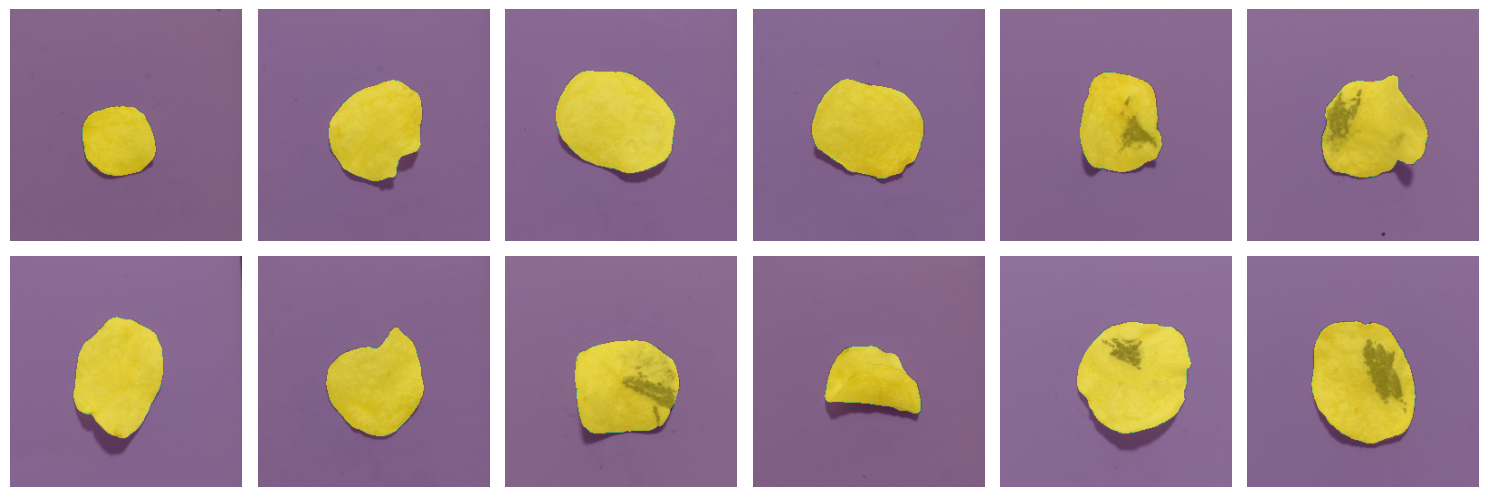

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [ ]:
json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO1_29_01_24_metricas.json'
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO3_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.0024,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice=train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.4863, val cost: 0.3920,train acc: 0.9206, val acc: 0.9747,dice: 0.91630, iou: 0.84553
epoch: 1, mb: 15, train cost: 0.3522, val cost: 0.3306,train acc: 0.9858, val acc: 0.9908,dice: 0.96790, iou: 0.93780
epoch: 2, mb: 15, train cost: 0.3074, val cost: 0.2914,train acc: 0.9930, val acc: 0.9949,dice: 0.98165, iou: 0.96396
epoch: 3, mb: 15, train cost: 0.2695, val cost: 0.2574,train acc: 0.9946, val acc: 0.9948,dice: 0.98154, iou: 0.96374
epoch: 4, mb: 15, train cost: 0.2369, val cost: 0.2216,train acc: 0.9960, val acc: 0.9960,dice: 0.98586, iou: 0.97211
epoch: 5, mb: 15, train cost: 0.2016, val cost: 0.1883,train acc: 0.9963, val acc: 0.9963,dice: 0.98682, iou: 0.97399
epoch: 6, mb: 15, train cost: 0.1692, val cost: 0.1561,train acc: 0.9968, val acc: 0.9970,dice: 0.98902, iou: 0.97828
epoch: 7, mb: 15, train cost: 0.1380, val cost: 0.1267,train acc: 0.9969, val acc: 0.9971,dice: 0.98946, iou: 0.97914
epoch: 8, mb: 15, train cost: 0.1100, val cost: 0.1021,t

In [ ]:
import json
json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO3_29_01_24_metricas.json'
# permiter convertir el tensor a valores escalares
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO4_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.0552,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice=train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.3213, val cost: 0.1439,train acc: 0.9515, val acc: 0.9928,dice: 0.97467, iou: 0.95059
epoch: 1, mb: 15, train cost: 0.0550, val cost: 0.0344,train acc: 0.9924, val acc: 0.9930,dice: 0.97494, iou: 0.95110
epoch: 2, mb: 15, train cost: 0.0280, val cost: 0.0271,train acc: 0.9908, val acc: 0.9899,dice: 0.96247, iou: 0.92765
epoch: 3, mb: 15, train cost: 0.0206, val cost: 0.0138,train acc: 0.9929, val acc: 0.9955,dice: 0.98396, iou: 0.96843
epoch: 4, mb: 15, train cost: 0.0125, val cost: 0.0114,train acc: 0.9956, val acc: 0.9960,dice: 0.98558, iou: 0.97158
epoch: 5, mb: 15, train cost: 0.0169, val cost: 0.0129,train acc: 0.9936, val acc: 0.9954,dice: 0.98373, iou: 0.96799
epoch: 6, mb: 15, train cost: 0.0125, val cost: 0.0151,train acc: 0.9953, val acc: 0.9942,dice: 0.97928, iou: 0.95940
epoch: 7, mb: 15, train cost: 0.0121, val cost: 0.0099,train acc: 0.9955, val acc: 0.9964,dice: 0.98701, iou: 0.97436
epoch: 8, mb: 15, train cost: 0.0109, val cost: 0.0099,t

In [ ]:
json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO4_29_01_24_metricas.json'
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO5_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.3,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice=train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.2077, val cost: 0.0296,train acc: 0.9495, val acc: 0.9908,dice: 0.96780, iou: 0.93761
epoch: 1, mb: 15, train cost: 0.0181, val cost: 0.0155,train acc: 0.9933, val acc: 0.9945,dice: 0.98044, iou: 0.96162
epoch: 2, mb: 15, train cost: 0.0177, val cost: 0.0216,train acc: 0.9936, val acc: 0.9914,dice: 0.96849, iou: 0.93890
epoch: 3, mb: 15, train cost: 0.0163, val cost: 0.0135,train acc: 0.9939, val acc: 0.9950,dice: 0.98220, iou: 0.96503
epoch: 4, mb: 15, train cost: 0.0131, val cost: 0.0132,train acc: 0.9952, val acc: 0.9952,dice: 0.98261, iou: 0.96582
epoch: 5, mb: 15, train cost: 0.0175, val cost: 0.0363,train acc: 0.9933, val acc: 0.9878,dice: 0.95797, iou: 0.91933
epoch: 6, mb: 15, train cost: 0.0212, val cost: 0.0164,train acc: 0.9918, val acc: 0.9936,dice: 0.97715, iou: 0.95531
epoch: 7, mb: 15, train cost: 0.0755, val cost: 0.0398,train acc: 0.9846, val acc: 0.9900,dice: 0.96518, iou: 0.93271
epoch: 8, mb: 15, train cost: 0.0266, val cost: 0.0214,t

In [ ]:
json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO5_29_01_24_metricas.json'
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO6_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 0.3,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice=train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.2077, val cost: 0.0293,train acc: 0.9496, val acc: 0.9912,dice: 0.96895, iou: 0.93978
epoch: 1, mb: 15, train cost: 0.0184, val cost: 0.0180,train acc: 0.9931, val acc: 0.9944,dice: 0.97964, iou: 0.96010
epoch: 2, mb: 15, train cost: 0.0205, val cost: 0.0206,train acc: 0.9923, val acc: 0.9934,dice: 0.97614, iou: 0.95339
epoch: 3, mb: 15, train cost: 0.0164, val cost: 0.0141,train acc: 0.9934, val acc: 0.9953,dice: 0.98337, iou: 0.96729
epoch: 4, mb: 15, train cost: 0.0191, val cost: 0.0141,train acc: 0.9933, val acc: 0.9949,dice: 0.98187, iou: 0.96439
epoch: 5, mb: 15, train cost: 0.0166, val cost: 0.0163,train acc: 0.9941, val acc: 0.9937,dice: 0.97766, iou: 0.95631
epoch: 6, mb: 15, train cost: 0.0154, val cost: 0.0115,train acc: 0.9944, val acc: 0.9957,dice: 0.98455, iou: 0.96957
epoch: 7, mb: 15, train cost: 0.0188, val cost: 0.0139,train acc: 0.9932, val acc: 0.9946,dice: 0.98056, iou: 0.96187
epoch: 8, mb: 15, train cost: 0.0171, val cost: 0.0125,t

In [ ]:
json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO6_29_01_24_metricas.json'
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)

In [ ]:
save_path = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO7_29_01_24.pt'
store_every = 15
torch.manual_seed(42)
model = UNET_potato_model(3, 16, 2)
epochs = 50
optimiser_unet = torch.optim.Adam(model.parameters(), lr= 0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 3,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train_loss_h, train_acc_h, val_loss_h, val_acc_h, train_IoU,val_dice=train(model, optimiser_unet, scheduler, epochs, store_every, save_path)

epoch: 0, mb: 15, train cost: 0.3281, val cost: 0.1121,train acc: 0.8475, val acc: 0.9829,dice: 0.93823, iou: 0.88366
epoch: 1, mb: 15, train cost: 0.0695, val cost: 0.0464,train acc: 0.9787, val acc: 0.9815,dice: 0.93468, iou: 0.87737
epoch: 2, mb: 15, train cost: 0.0433, val cost: 0.0339,train acc: 0.9832, val acc: 0.9879,dice: 0.95625, iou: 0.91616
epoch: 3, mb: 15, train cost: 0.0382, val cost: 0.0310,train acc: 0.9863, val acc: 0.9894,dice: 0.96024, iou: 0.92352
epoch: 4, mb: 15, train cost: 0.0256, val cost: 0.0243,train acc: 0.9900, val acc: 0.9911,dice: 0.96633, iou: 0.93486
epoch: 5, mb: 15, train cost: 0.0660, val cost: 0.0557,train acc: 0.9774, val acc: 0.9837,dice: 0.94161, iou: 0.88967
epoch: 6, mb: 15, train cost: 0.0439, val cost: 0.0507,train acc: 0.9878, val acc: 0.9787,dice: 0.91595, iou: 0.84494
epoch: 7, mb: 15, train cost: 0.0573, val cost: 0.0420,train acc: 0.9811, val acc: 0.9844,dice: 0.94258, iou: 0.89140
epoch: 8, mb: 15, train cost: 0.0412, val cost: 0.0330,t

In [ ]:

json_metrics = '/content/drive/MyDrive/MODELOUNET29_01_24/DATA/MODELO7_29_01_24_metricas.json'
metrics_dict = {
        "train_loss": train_loss_h,
        "val_loss": val_loss_h,
        "train_acc": train_acc_h,
        "val_acc": val_acc_h,
        "IoU": train_IoU,
        "dice":val_dice
    }
with open(json_metrics,'w') as json_metrics:
  json.dump(metrics_dict,json_metrics)